In [63]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn import ensemble, linear_model, neighbors, svm, tree, neural_network
import xgboost as xgb
from sklearn import tree
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import FunctionTransformer
# import cross_val_score
from sklearn.model_selection import cross_val_score
# import dill
import pickle

In [64]:
path = "data/ebw_data.csv"


In [65]:
df = pd.read_csv(path)


In [66]:
# 1. Предварительная обработка датасета.

In [67]:
# 1.1. Проверка наличия пропусков в данных.


In [68]:
df.isnull().sum() # пропусков нет


IW       0
IF       0
VW       0
FP       0
Depth    0
Width    0
dtype: int64

In [69]:
df.describe() # описательная статистика

,IW,IF,VW,FP,Depth,Width
count,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000
mean,45.666667,141.333333,8.638889,78.333333,1.195556,1.970417
std,1.678363,5.145763,2.061078,21.493530,0.225081,0.279040
min,43.000000,131.000000,4.500000,50.000000,0.800000,1.680000
25%,44.000000,139.000000,8.000000,60.000000,1.080000,1.760000
50%,45.500000,141.000000,9.000000,80.000000,1.200000,1.840000
75%,47.000000,146.000000,10.000000,80.000000,1.290000,2.050000
max,49.000000,150.000000,12.000000,125.000000,1.760000,2.600000


In [70]:
# 1.2. Удаление дубликатов.


In [71]:
df.drop_duplicates(inplace=True) # дубликатов нет


In [72]:
df.shape # размер датасета


(65, 6)

In [73]:
df.describe() # описание данных


,IW,IF,VW,FP,Depth,Width
count,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000
mean,45.769231,140.907692,8.669231,80.000000,1.192615,1.977077
std,1.674900,5.070512,2.097761,21.650635,0.234136,0.281945
min,43.000000,131.000000,4.500000,50.000000,0.800000,1.680000
25%,44.000000,139.000000,8.000000,60.000000,1.040000,1.780000
50%,46.000000,141.000000,9.000000,80.000000,1.200000,1.840000
75%,47.000000,146.000000,10.000000,80.000000,1.280000,2.080000
max,49.000000,150.000000,12.000000,125.000000,1.760000,2.600000


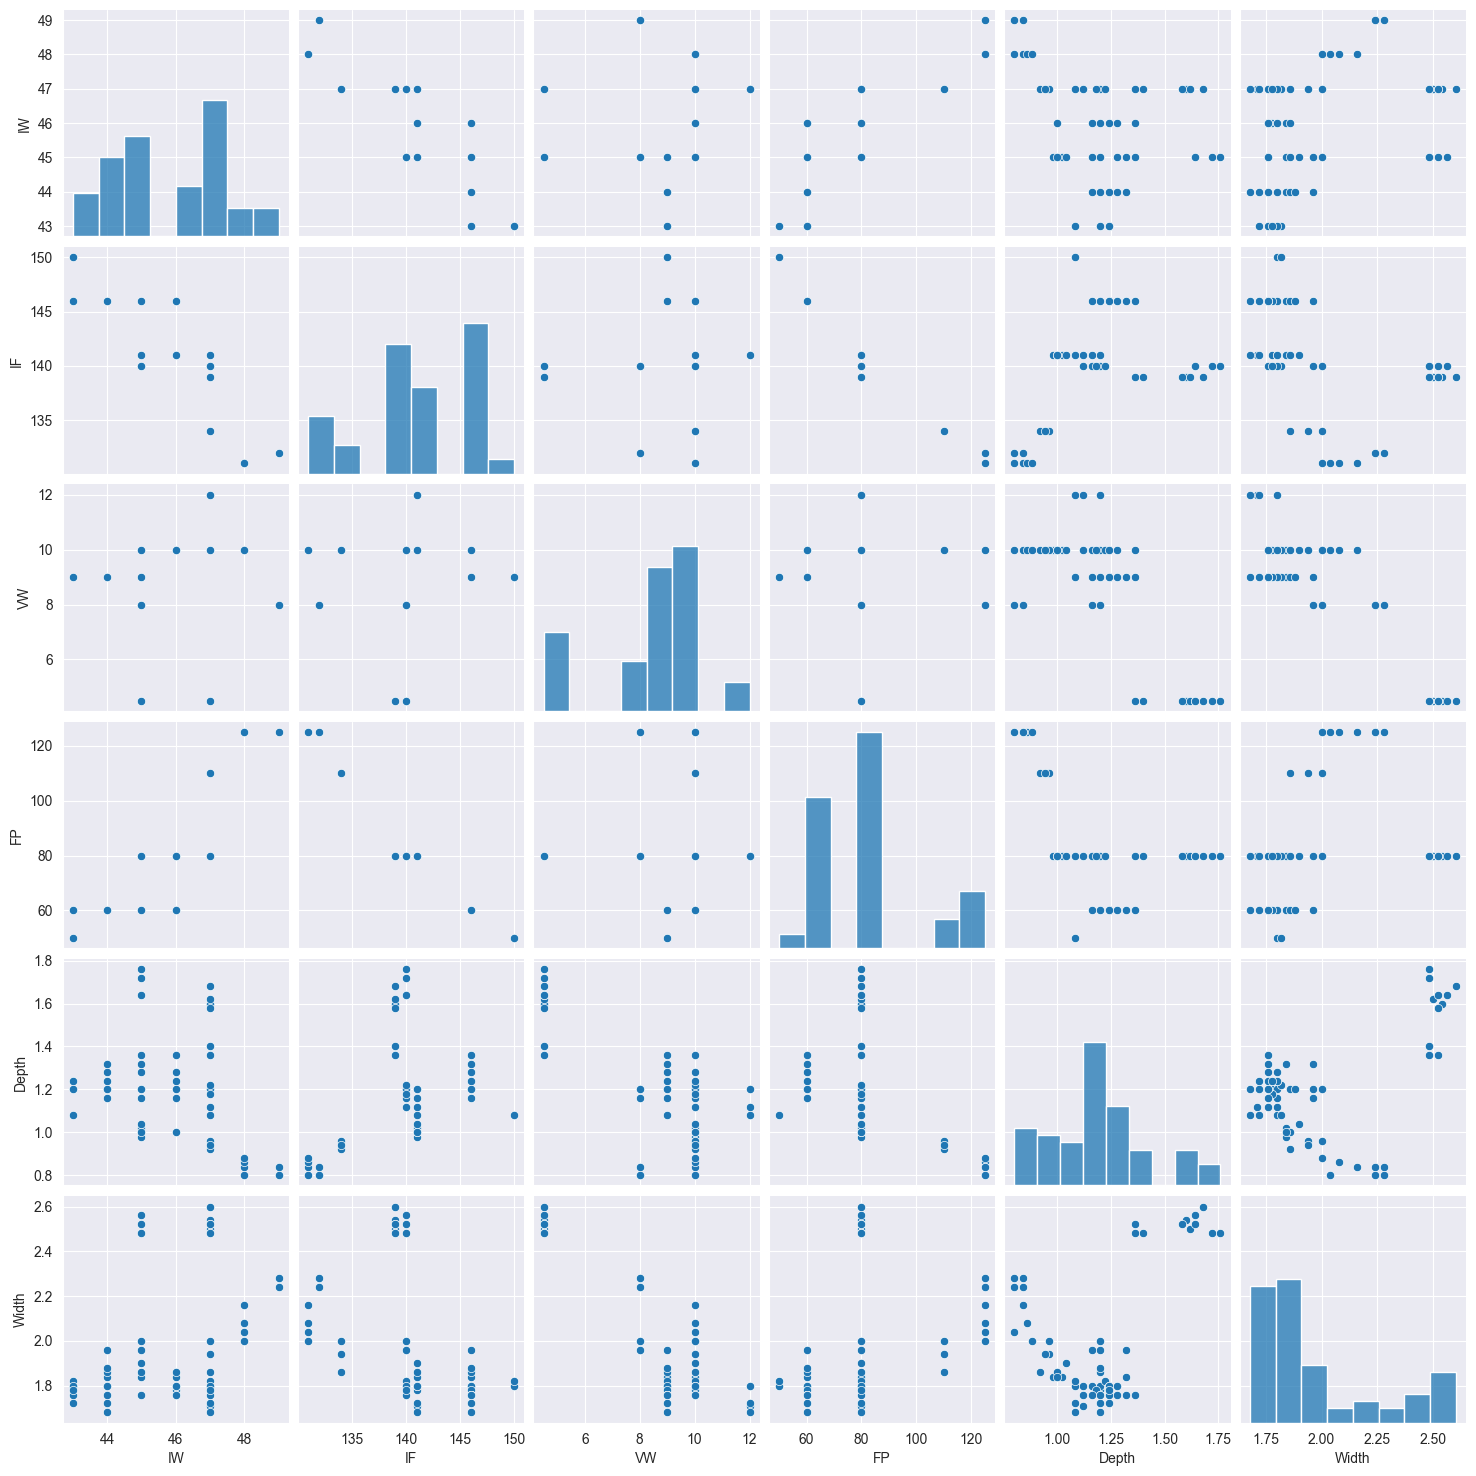

In [74]:
sns.pairplot(df) # визуализация данных


<AxesSubplot: >

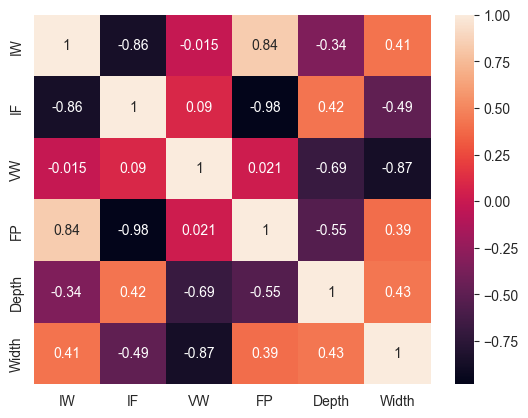

In [75]:
# show the correlation matrix
sns.heatmap(df.corr(), annot=True) # визуализация корреляции


IW          AxesSubplot(0.125,0.53;0.227941x0.35)
IF       AxesSubplot(0.398529,0.53;0.227941x0.35)
VW       AxesSubplot(0.672059,0.53;0.227941x0.35)
FP          AxesSubplot(0.125,0.11;0.227941x0.35)
Depth    AxesSubplot(0.398529,0.11;0.227941x0.35)
Width    AxesSubplot(0.672059,0.11;0.227941x0.35)
dtype: object

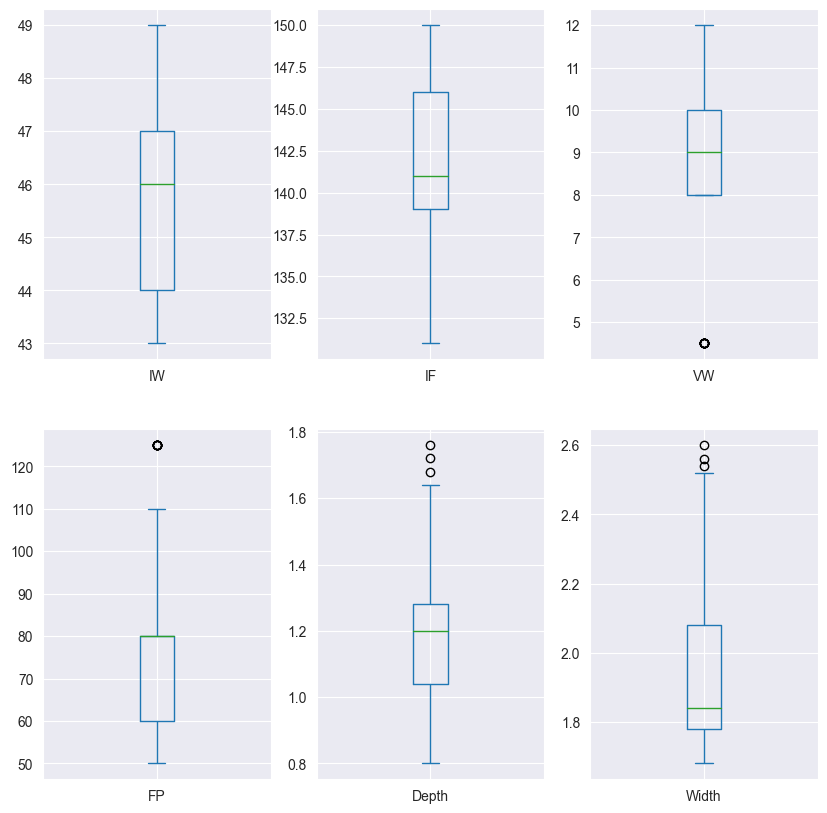

In [76]:
#show boxplot for each column in subplots 2 rows 3 columns
df.plot(kind='box', subplots=True, layout=(2,3), sharex=False, sharey=False, figsize=(10,10)) # визуализация выбросов


In [77]:
#handle outliers
def reduce_outliers(df, col):
    """
    редукция выбросов в столбце
    """
    q1 = df[col].quantile(0.25) # 1 квартиль
    q3 = df[col].quantile(0.75) # 3 квартиль
    iqr = q3 - q1 # межквартильный размах
    lower_bound = q1 - (1.5 * iqr) # нижняя граница
    upper_bound = q3 + (1.5 * iqr) # верхняя граница
    df.loc[df[col] < lower_bound, col] = lower_bound # замена выбросов на нижнюю границу
    df.loc[df[col] > upper_bound, col] = upper_bound # замена выбросов на верхнюю границу

for col in df.columns:
    reduce_outliers(df, col) # редукция выбросов


IW          AxesSubplot(0.125,0.53;0.227941x0.35)
IF       AxesSubplot(0.398529,0.53;0.227941x0.35)
VW       AxesSubplot(0.672059,0.53;0.227941x0.35)
FP          AxesSubplot(0.125,0.11;0.227941x0.35)
Depth    AxesSubplot(0.398529,0.11;0.227941x0.35)
Width    AxesSubplot(0.672059,0.11;0.227941x0.35)
dtype: object

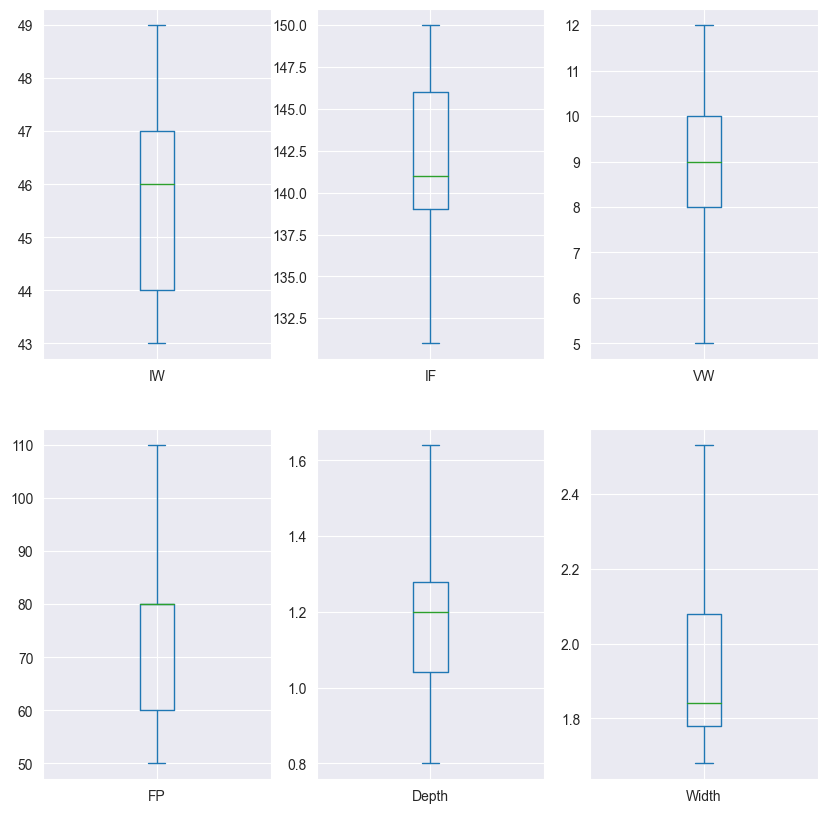

In [78]:
#show boxplot for each column in subplots 2 rows 3 columns
df.plot(kind='box', subplots=True, layout=(2,3), sharex=False, sharey=False, figsize=(10,10))


In [79]:
# 2. Построение модели.


In [80]:
# 2.1. Разделение данных на обучающую и тестовую выборки.


In [81]:
y1 = df['Depth'] # целевая переменная
y2 = df['Width'] # целевая переменная
X = df.drop(['Depth', 'Width'], axis=1) # признаки


In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, y1, test_size=0.2, random_state=42) # разделение данных на обучающую и тестовую выборки


In [83]:
def remove_outliers(df: pd.DataFrame) -> pd.DataFrame:
    """
    удаление выбросов
    """
    def calculate_outliers(data):
        q25 = data.quantile(0.25)
        q75 = data.quantile(0.75)
        iqr = q75 - q25
        bounds = (q25 - 1.5 * iqr, q75 + 1.5 * iqr)
        return bounds

    df = df.copy()
    for col in df.columns:
        bounds = calculate_outliers(df[col])
        df.loc[df[col] < bounds[0], col] = bounds[0]
        df.loc[df[col] > bounds[1], col] = bounds[1]
    return df

In [84]:
preprocessing = Pipeline([
    ('outlier_remover', FunctionTransformer(remove_outliers)), # удаление выбросов
    ('scaler', StandardScaler()) # масштабирование данных
]) # предобработка данных

In [85]:
models = [
    ('xgb', xgb.XGBRegressor()),
    ('rf', RandomForestRegressor(n_estimators=100, max_depth=3, random_state=42)),
    ('mlp', MLPRegressor(hidden_layer_sizes=(100, 100), max_iter=1000, random_state=42)),
] # модели

In [86]:
MLA_columns = []
MLA_compare = pd.DataFrame(columns = MLA_columns)
row_index = 0
for name, model in models:
    X_train, X_test, y_train, y_test = train_test_split(X, y1, test_size=0.2, random_state=42)


    pipe = Pipeline([
        ('preprocessing', preprocessing),
        (name, model),
    ])
    score1 = cross_val_score(pipe, X, y1, cv=5, scoring='neg_mean_squared_error') # оценка качества модели
    MLA_name = name
    MLA_compare.loc[row_index,'Model Name'] = MLA_name
    MLA_compare.loc[row_index, 'mean_mse'] = -score1.mean()
    MLA_compare.loc[row_index, 'std_mse'] = score1.std()
    row_index+=1


In [87]:
MLA_compare.sort_values(by = ['mean_mse'], ascending = True, inplace = True)

In [88]:
MLA_compare # сравнение моделей

,Model Name,mean_mse,std_mse
0,xgb,0.019090,0.012301
1,rf,0.027020,0.024680
2,mlp,0.720038,0.812265


In [89]:
#best model
MLA_compare.iloc[0,0] # лучшая модель


'xgb'

In [90]:
#deploys best model
X_train, X_test, y_train, y_test = train_test_split(X, y1, test_size=0.2, random_state=42)
pipe = Pipeline([
    ('preprocessing', preprocessing),
    ('xgb', xgb.XGBRegressor()),
])
pipe = xgb.XGBRegressor().fit(X_train, y_train)
# pipe.fit(X_train, y_train) # обучение модели
y_pred = pipe.predict(X_test) # предсказание
print('MSE:', mean_squared_error(y_test, y_pred)) # оценка качества модели
print('R2:', r2_score(y_test, y_pred)) # оценка качества модели


MSE: 0.004429925060284013
R2: 0.9219563281640399


In [91]:
# dill.dump(pipe, open('model1.pkl', 'wb')) # сохранение модели
pickle.dump(pipe, open('model1.pkl', 'wb')) # сохранение модели


In [92]:
#все также для ширины
X_train, X_test, y_train, y_test = train_test_split(X, y2, test_size=0.2, random_state=42)
pipe = Pipeline([
    ('preprocessing', preprocessing),
    ('xgb', xgb.XGBRegressor()),
])
pipe = xgb.XGBRegressor().fit(X_train, y_train)
# pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print('MSE:', mean_squared_error(y_test, y_pred))
print('R2:', r2_score(y_test, y_pred))


MSE: 0.0029883251047020535
R2: 0.9563518164718033


In [93]:
# dill.dump(pipe, open('model2.pkl', 'wb'))

pickle.dump(pipe, open('model2.pkl', 'wb'))
